<a href="https://colab.research.google.com/github/phytometrics/plant_phenotyping_python/blob/dev/notebooks/dl_frameworks_example.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Load example image for inference

In [7]:
import cv2

import matplotlib.pyplot as plt
import numpy as np
from skimage import data

(512, 512, 3)
uint8


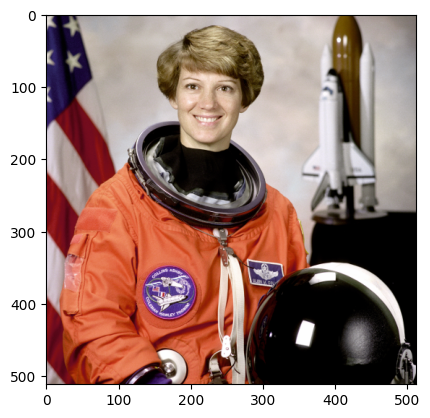

In [8]:
image = getattr(data, "astronaut")()
print(image.shape)
print(image.dtype)
plt.imshow(image)
plt.show()


## tensorflow.keras (tensorflow 2.0 and higher) usage

Data Layout: NHWC

Originally, Keras was an independent neural network library, but since TensorFlow 2.0, it has been integrated as an official API of TensorFlow. As a result, many recent TensorFlow documents and examples are written using Keras. As of December 2023, tensorflow1.0 is not supported in Colaboratory, so it will not be discussed here.

In [3]:
import tensorflow as tf

In [4]:
# shares the same code with tensorflow
gpus = tf.config.list_physical_devices('GPU')
print("Num GPUs Available: ", len(gpus))
print('GPU name: ',gpus )

Num GPUs Available:  1
GPU name:  [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [7]:
model = tf.keras.applications.MobileNetV3Small(input_shape=(224,224,3),
                                               weights="imagenet",
                                               include_preprocessing=True)

print(model.inputs)
print(model.outputs)

10734624/10734624 [==============================] - 0s 0us/step
[<KerasTensor: shape=(None, 224, 224, 3) dtype=float32 (created by layer 'input_3')>]
[<KerasTensor: shape=(None, 1000) dtype=float32 (created by layer 'Predictions')>]


In [9]:
inputs = cv2.resize(image, (224,224))
inputs = np.expand_dims(inputs, axis=0).astype(np.float32)
print(inputs.dtype)
print(inputs.shape)

outputs = model.predict(inputs)
print(outputs.shape)

float32
(1, 224, 224, 3)
1/1 [==============================] - 4s 4s/step
(1, 1000)


In [10]:
# release gpu memory
tf.keras.backend.clear_session()

## PyTorch usage

Data Layout: NCHW

In [5]:
import torch
import torchvision
import torchvision.transforms as transforms
from torchsummary import summary

In [2]:
print("GPU Availability:", torch.cuda.is_available())
print("Num GPUs available", torch.cuda.device_count())
print("GPU Name", torch.cuda.get_device_name())

GPU Availability: True
Num GPUs available 1
GPU Name Tesla T4


In [3]:
# Load the pre-trained MobileNet v3 small model with predefined weights
model = torchvision.models.mobilenet_v3_small(pretrained=True)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)
# Switch the model to evaluation mode.
model.eval()

# In PyTorch, the models are defined dynamically,
# which means that the input and output shapes are not fixed.
# You have to run the model to get the input and output details
# Using torchsummary, you can get info on how the tensors are modified.
summary(model, input_size=(3,224,224))

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V3_Small_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V3_Small_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/mobilenet_v3_small-047dcff4.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v3_small-047dcff4.pth
100%|██████████| 9.83M/9.83M [00:00<00:00, 56.6MB/s]


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 112, 112]             432
       BatchNorm2d-2         [-1, 16, 112, 112]              32
         Hardswish-3         [-1, 16, 112, 112]               0
            Conv2d-4           [-1, 16, 56, 56]             144
       BatchNorm2d-5           [-1, 16, 56, 56]              32
              ReLU-6           [-1, 16, 56, 56]               0
 AdaptiveAvgPool2d-7             [-1, 16, 1, 1]               0
            Conv2d-8              [-1, 8, 1, 1]             136
              ReLU-9              [-1, 8, 1, 1]               0
           Conv2d-10             [-1, 16, 1, 1]             144
      Hardsigmoid-11             [-1, 16, 1, 1]               0
SqueezeExcitation-12           [-1, 16, 56, 56]               0
           Conv2d-13           [-1, 16, 56, 56]             256
      BatchNorm2d-14           [-1, 16,

In [9]:
inputs = cv2.resize(image, (224, 224), interpolation=cv2.INTER_LINEAR)
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])
inputs = (inputs - mean) / std
inputs = inputs.astype("float")
inputs = torch.from_numpy(inputs).permute(2, 0, 1).float().unsqueeze(0)

# load to gpu if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
inputs = inputs.to(device)

print(inputs.shape)

torch.Size([1, 3, 224, 224])


In [10]:
# The torch.no_grad() context manager tells PyTorch not to calculate gradients
# during the forward pass. This reduces memory consumption and speeds up computations
# since gradients are not needed for inference.
with torch.no_grad():
    output = model(inputs)
prediction = output.cpu().detach().numpy()
print(prediction.shape)


(1, 1000)


In [11]:
# release gpu memory
del model

## ONNX usage
Data Layout: ONNX does not inherently dictate a specific data layout like NHWC (batch size, height, width, channels) or NCHW (batch size, channels, height, width) for tensor representations. So, an ONNX model could use either NHWC or NCHW format, depending on how and where it was originally created.

In [12]:
# Model from https://github.com/onnx/models
# Apache-2.0 license
# The onnx model was converted from torchhub mobilenetv3,
# so the data layout and preprocess should follow the original
!wget https://github.com/onnx/models/raw/main/Computer_Vision/mobilenet_v3_small_Opset18_torch_hub/mobilenet_v3_small_Opset18.onnx

--2023-12-18 01:10:54--  https://github.com/onnx/models/raw/main/Computer_Vision/mobilenet_v3_small_Opset18_torch_hub/mobilenet_v3_small_Opset18.onnx
Resolving github.com (github.com)... 192.30.255.112
Connecting to github.com (github.com)|192.30.255.112|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://media.githubusercontent.com/media/onnx/models/main/Computer_Vision/mobilenet_v3_small_Opset18_torch_hub/mobilenet_v3_small_Opset18.onnx [following]
--2023-12-18 01:10:54--  https://media.githubusercontent.com/media/onnx/models/main/Computer_Vision/mobilenet_v3_small_Opset18_torch_hub/mobilenet_v3_small_Opset18.onnx
Resolving media.githubusercontent.com (media.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to media.githubusercontent.com (media.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10181029 (9.7M) [application/octet-stream]
Saving to:

In [13]:
!pip install -q onnxruntime-gpu
import onnxruntime as ort

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 157.1/157.1 MB 7.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 3.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 kB 11.4 MB/s eta 0:00:00


In [14]:
# Check CUDAExecutionProvider is in this list,
# otherwise, check you environment and ort installation
print("Available providers:", ort.get_available_providers())

Available providers: ['TensorrtExecutionProvider', 'CUDAExecutionProvider', 'AzureExecutionProvider', 'CPUExecutionProvider']


In [15]:
providers = [
    'CUDAExecutionProvider', 'CPUExecutionProvider' \
    if "CUDAExecutionProvider" in ort.get_available_providers() \
    else ['CPUExecutionProvider']
    ]

model = ort.InferenceSession("/content/mobilenet_v3_small_Opset18.onnx",
                             providers=providers)

In [16]:
input_nodes = model.get_inputs()
output_nodes = model.get_outputs()

for input in input_nodes:
    print(f"Name: {input.name}")
    print(f"Shape: {input.shape}")
    print(f"Type: {input.type}")

for output in output_nodes:
    print(f"Name: {output.name}")
    print(f"Shape: {output.shape}")
    print(f"Type: {output.type}")



Name: x
Shape: [1, 3, 224, 224]
Type: tensor(float)
Name: 400
Shape: [1, 1000]
Type: tensor(float)


In [17]:
inputs = cv2.resize(image, (224, 224), interpolation=cv2.INTER_LINEAR)
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])
inputs = (inputs - mean) / std
inputs = inputs.transpose(2,0,1)
inputs = np.expand_dims(inputs,axis=0)
inputs = inputs.astype("float32")
print(inputs.dtype)
print(inputs.shape)

float32
(1, 3, 224, 224)


In [18]:
input_info = {model.get_inputs()[0].name: inputs}
outputs = model.run(None, input_info)
# output length depends on the output node numbers
print(len(outputs))
print(outputs[0].shape)

1
(1, 1000)
